In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import folium

import datetime

from IPython.core.display import HTML

EARTH_RADIUS = 6371 # km
%matplotlib inline

In [68]:
df = pd.read_csv('pings.csv',header=None,names=['time','acc','lon','lat'])
df.time = pd.to_datetime(df.time, infer_datetime_format=True) + datetime.timedelta(hours=6)
df = df.set_index(df.time)
df.sort_index(inplace=True)
df['dt'] = df.time.diff().astype('<m8[s]').fillna(9999999)
# Get rid of time column (now resides in index)
df.drop('time', axis=1, inplace=True)
# Remove points in the US
df.drop(df.index[0:2], inplace=True)
df.head()

,acc,lon,lat,dt
time,,,,
2015-06-02 22:36:42.000000,10,100.753538,13.704107,153622
2015-06-02 22:37:47.029999,18,100.757832,13.719487,65
2015-06-02 22:39:15.039000,8,100.749045,13.729378,88
2015-06-02 22:40:44.036000,12,100.726632,13.729938,88
2015-06-02 22:42:13.030999,28,100.702625,13.732482,88


Make a new column with a tuple of lat and lon to make for easier ploting

In [69]:
df['latlon'] = df[['lat','lon']].apply(tuple, axis=1)

Plot all points using folium

In [70]:
def inline_map(m, width=600, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

m = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=5,tiles='OpenStreetMap')
m.line(df.latlon)
    
inline_map(m)

Messy! Make some new columns before we clean it up.

In [71]:
def haversine(loc1, loc2):
    lat1, lon1, lat2, lon2 = map(np.radians, [loc1[0],loc1[1],loc2[0],loc2[1]])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    return c * EARTH_RADIUS

def dhaversine(dlat,dlon):
    return haversine((0.0,0.0),(dlat,dlon))

### Calculate differentials and derivatives

In [72]:
df.sort_index(inplace=True)

#df['dr'] = dhaversine( df.lat.diff(), df.lon.diff() )
#df['dv'] = df.dr.diff()

# Compute dr's by day
# (in case the start recording location is different from the end location the day before)
dr = df.groupby(pd.TimeGrouper('D')).apply(lambda x: dhaversine( x.lat.diff(), x.lon.diff() )).fillna(0)
dr.index = dr.index.droplevel(0)
df['dr'] = dr
df['drdt'] =  df['dr'] / (df.dt/3600)

dv = df.groupby(pd.TimeGrouper('D')).apply(lambda x: x.dr.diff()).fillna(0)
dv.index = dv.index.droplevel(0)
df['dv'] = dv
df['dvdt'] = df['dv'] / (df.dt/3600)

# Cumulative distance by day
df['cumr'] = df.groupby([df.index.month, df.index.day])['dr'].apply(lambda x: x.cumsum())

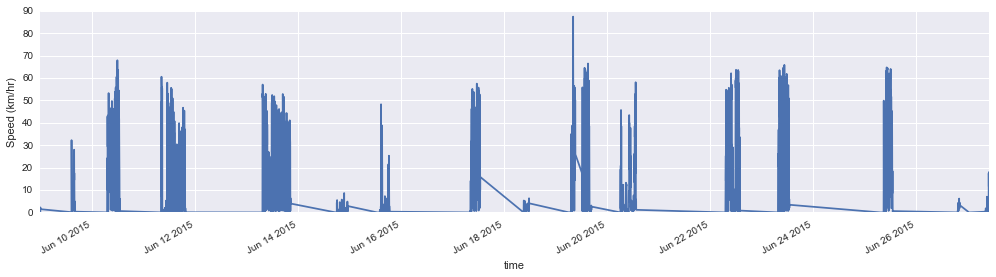

In [73]:
plt.figure(figsize=(17,4))
df['20150609':'20150627'].drdt.plot()
plt.ylabel('Speed (km/hr)')
plt.show()

## A single day of riding

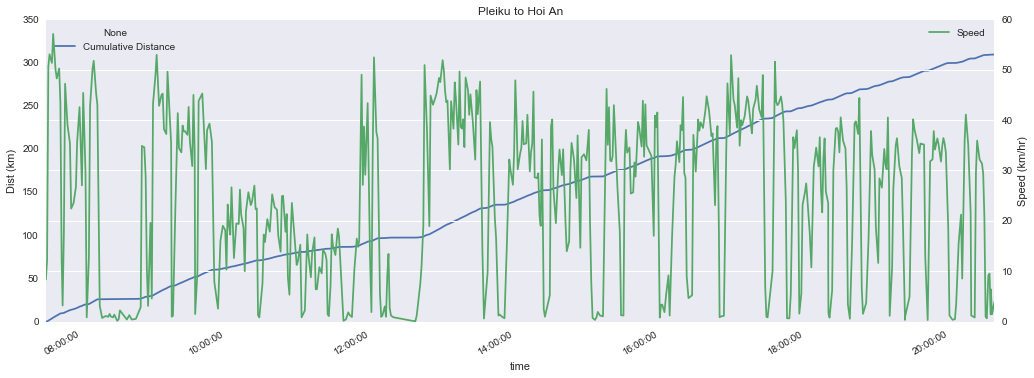

In [226]:
plt.figure(figsize=(17,6))
df['20150613'].iloc[1:].cumr.plot()
plt.ylabel('Dist (km)')
plt.legend(['Cumulative Distance'])
df['20150613'].iloc[1:].drdt.plot(secondary_y=True)
plt.legend(['Speed'])
plt.title(df.label['20150613'][0])
plt.ylabel('Speed (km/hr)')
plt.show()

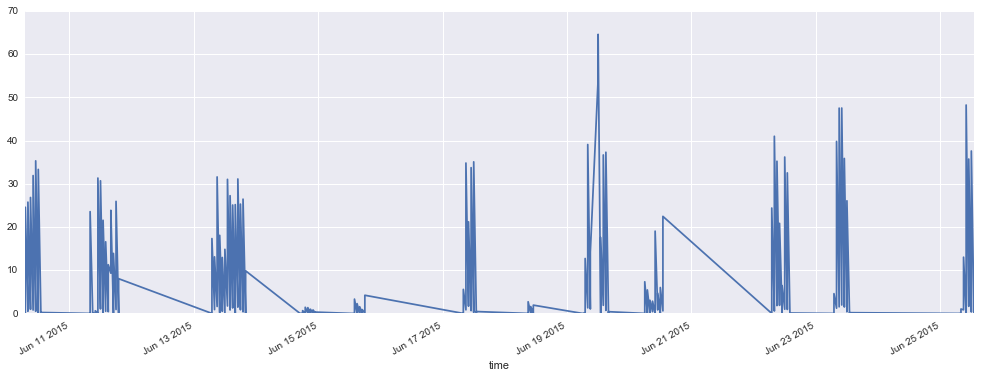

In [75]:
plt.figure(figsize=(17,6))
sday = '20150610'
eday = '20150625'
group = df[sday:eday].groupby(pd.TimeGrouper('H')).apply(lambda x: x.dr.cumsum())
group.index = group.index.droplevel(1)
#group.filter(lambda group: group.index[0] > 0)
# Days with over 50 km traveled
#group = group.filter(lambda group: group.cumr.iloc[-1] > 50.0)
group.plot(subplots=False, layout=(3,3))
plt.show()

In [83]:
df['label'] = np.nan
df['notes'] = np.nan

## Trip lengths

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


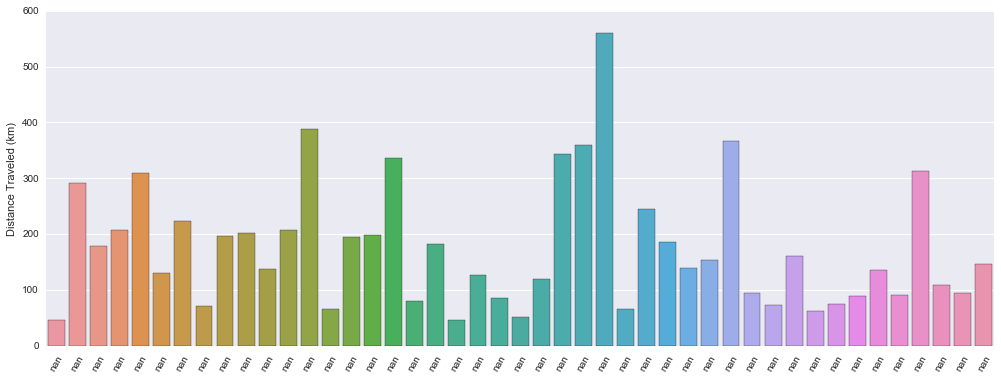

time
2015-06-07 05:32:18.000000    Ho Chi Minh to Da Lat
2015-06-07 05:32:32.000000    Ho Chi Minh to Da Lat
2015-06-07 05:33:35.000000    Ho Chi Minh to Da Lat
2015-06-07 05:35:33.239000    Ho Chi Minh to Da Lat
2015-06-07 05:36:34.240000    Ho Chi Minh to Da Lat
2015-06-07 05:38:33.244999    Ho Chi Minh to Da Lat
2015-06-07 05:39:33.240000    Ho Chi Minh to Da Lat
2015-06-07 05:40:36.243000    Ho Chi Minh to Da Lat
2015-06-07 05:41:38.230000    Ho Chi Minh to Da Lat
2015-06-07 05:43:34.230999    Ho Chi Minh to Da Lat
2015-06-07 05:45:35.000000    Ho Chi Minh to Da Lat
2015-06-07 05:46:42.233999    Ho Chi Minh to Da Lat
2015-06-07 05:48:40.221999    Ho Chi Minh to Da Lat
2015-06-07 05:49:41.226999    Ho Chi Minh to Da Lat
2015-06-07 05:51:41.230999    Ho Chi Minh to Da Lat
2015-06-07 05:53:41.000000    Ho Chi Minh to Da Lat
2015-06-07 05:55:42.227999    Ho Chi Minh to Da Lat
2015-06-07 05:57:39.000000    Ho Chi Minh to Da Lat
2015-06-07 05:58:39.000000    Ho Chi Minh to Da Lat
2015-06

In [232]:
sday = '20150602'
eday = '20151125'
group = df[sday:eday].groupby(pd.TimeGrouper('D'))

plt.figure(figsize=(17,6))
trips = pd.DataFrame( group.dr.agg(sum), index=group.indices).sort()
# Filter extremes
trips = trips[ trips['dr'] > 30]
trips = trips[ trips['dr'] < 600]
# Obnoxious default formatting for dates
date_labels = trips.index.strftime('%m/%d') + df.label[trips.index]

sns.barplot(trips.index, trips['dr'])
plt.xticks(rotation=60)
plt.gca().set_xticklabels(date_labels)
plt.ylabel('Distance Traveled (km)')
plt.show()
t = trips.index.strftime('%Y%m%d')
df.label[t[1]]

In [209]:
df['20150610'].head()

,acc,lon,lat,dt,latlon,dr,drdt,dv,dvdt,cumr,transport,notes,label
time,,,,,,,,,,,,,
2015-06-10 07:01:20.000000,23,108.434777,11.951552,53139,"(11.951552, 108.434777)",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-10 07:07:02.000000,26,108.434788,11.951557,342,"(11.951557, 108.434788)",0.001344,0.014143,0.001344,0.014143,0.001344,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-10 07:08:03.000000,25,108.434616,11.951171,61,"(11.951171, 108.434616)",0.046990,2.773154,0.045646,2.693862,0.048333,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-10 07:09:04.207000,21,108.435491,11.948321,61,"(11.948321, 108.435491)",0.331505,19.564228,0.284515,16.791074,0.379838,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-10 07:11:04.204999,25,108.433364,11.942407,119,"(11.942407, 108.433364)",0.698845,21.141532,0.367340,11.112810,1.078683,NaN,NaN,Da Lat to Buon Ma Thuot


## Labels days

In [203]:
df.loc['20150607','label'] = 'Ho Chi Minh to Da Lat'
df.loc['20150609','label'] = 'Da Lat to Buon Ma Thuot'
df.loc['20150611','label'] = 'Buon Ma Thuot to Pleiku'
df.loc['20150613','label'] = 'Pleiku to Hoi An'
df.loc['20150617','label'] = 'Hoi An to Hue'
df.loc['20150619','label'] = 'Hue to Phong Nha'
df.loc['20150622','label'] = 'Phong Nha to Vinh'
df.loc['20150623','label'] = 'Vinh to Ninh Binh'
df.loc['20150625','label'] = 'Ninh Binh to Ha Noi'

df.loc['20150629','label'] = 'Ha Noi to Phonsavan'
df.loc['20150630','label'] = 'Ha Noi to Phonsavan'
df.loc['20150701','label'] = 'Plain of Jars'
df.loc['20150702','label'] = 'Phonsavan to Luang Prabang'
df.loc['20150704','label'] = 'Luang Prabang to Chiang Rai'
df.loc['20150705','label'] = 'Luang Prabang to Chiang Rai'
df.loc['20150706','label'] = 'Chiang Rai'
df.loc['20150708','label'] = 'Chiang Rai to Chiang Mai'
df.loc['20150710','label'] = 'Chaing Mai Grand Canyon'

df.loc['20150711','label'] = 'Chaing Mai to Pai'
df.loc['20150712','label'] = 'Pai'
df.loc['20150713','label'] = 'Pai'
df.loc['20150714','label'] = 'Pai to Caves and Back'
df.loc['20150716','label'] = 'Pai to Mountain'
df.loc['20150717','label'] = 'Pai to Chiang Mai'

df.loc['20150824','label'] = 'Chiang Mai to Bangkok'
df.loc['20150825','label'] = 'Chiang Mai to Bangkok'
df.loc['20150826','label'] = 'Bangkok to Pinang'
df.loc['20150827','label'] = 'Bangkok to Pinang'
df.loc['20150829','label'] = 'Pinang'
df.loc['20150831','label'] = 'Pinang to Tanah Rata'

df.loc['20150902','label'] = 'Tanah Rata to Kuala Lumpur'

In [189]:
df['20150609'].head()

,acc,lon,lat,dt,latlon,dr,drdt,dv,dvdt,cumr,transport,notes,label
time,,,,,,,,,,,,,
2015-06-09 00:01:12.000000,216,108.434920,11.951488,1743,"(11.951488, 108.43492)",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-09 00:02:41.000000,176,108.434438,11.951614,89,"(11.951614, 108.434438)",0.055397,2.240776,0.055397,2.240776,0.055397,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-09 00:04:59.000000,221,108.434898,11.951408,138,"(11.951408, 108.434898)",0.056044,1.462029,0.000647,0.016891,0.111441,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-09 14:31:57.493999,4,108.436473,11.936588,52018,"(11.936588, 108.436473)",1.657189,0.114689,1.601144,0.110810,1.768630,NaN,NaN,Da Lat to Buon Ma Thuot
2015-06-09 14:32:05.503000,8,108.436432,11.936516,8,"(11.936516, 108.436432)",0.009213,4.145890,-1.647976,-741.589064,1.777843,NaN,NaN,Da Lat to Buon Ma Thuot


In [190]:


m = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=5,tiles='OpenStreetMap')
m.line(df['20150902'].latlon)
    
inline_map(m)